This notebook accompanies the **Talify Data Scientist Task - Report LV**

In [1]:
import pandas as pd
import numpy as np
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# formating data frames
pd.set_option('display.float_format', '{:,.2f}'.format)
pd.set_option('display.max_columns', None)

In [3]:
# style graphs
sns.set_style('whitegrid')

### Read and clean the data

In [4]:
df = pd.read_csv('data.csv')

In [5]:
# split category string into list
df.category = df.category.str.split(',')

In [6]:
# convert utc time to datestamp
df['date_published'] = pd.to_datetime(df.first_published, unit='ms')

#### Remove some data

* 3 duplicate post and channel id

 * rows 0 & 87 - all the same, except for small difference in the stats values - removed 87
 * rows 3 & 4 - different number of sales and revenue - combine sales and revenue
 * rows 114 & 121 - only difference first published time - removed later value 121 

* row 153 has 0 cost - remove

In [7]:
# combine rows 3 & 4
df.loc[3, 'ch_revenue'] = df.loc[3, 'ch_revenue'] + df.loc[4, 'ch_revenue']
df.loc[3, 'sales'] = df.loc[3, 'sales'] + df.loc[4, 'sales']

In [8]:
# remove unwanted rows
df = df.drop([4, 87, 121, 153])

In [9]:
# set min revenue as 0.01 to avoid inf ROI
df.loc[df.ch_revenue==0, 'ch_revenue'] = 0.01

In [10]:
# get the dependent variable roi
df['ch_roi'] = (df.ch_revenue - df.cost) / df.cost * 100

In [11]:
df.head()

,post_id,ch_id,ch_country,category,first_published,ch_subscriber_count,ch_avg10_views,ch_avg10_likes_per_dislikes,ch_avg10_likes_per_rates,ch_avg10_likes_per_views,ch_avg10_comments_per_views,ch_avg10_views_per_subs,ch_avg10_duration_m,view_count,ch_revenue,sales,cost,date_published,ch_roi
0,QZ3fs4vilTQ,UCW2G11dTUlkjZCW_0EaZK4Q,US,[24],"1,569,370,000,000.00",657000,"74,976.30",36.32,0.97,4.16,0.41,0.11,49.55,126203,275.18,4,"1,438.38",2019-09-25 00:06:40,-80.87
1,0vNj21Oii1Y,UCsrWoMiWGwjFo4toX4D8Hsg,TW,[1],"1,583,020,000,000.00",207000,"79,152.90",30.74,0.97,1.96,0.27,0.38,11.40,766109,"1,005.12",8,"1,025.73",2020-02-29 23:46:40,-2.01
2,Czeqxh3yMeU,UCJc3p1FsUXycsocQSQ2-_mg,NL,[24],"1,597,940,000,000.00",362000,"149,509.30",60.19,0.98,2.11,0.08,0.41,4.24,853005,"37,870.14",415,"67,692.94",2020-08-20 16:13:20,-44.06
3,_tad4DJbAOQ,UCH-y44M0pvwaZx2rTq0rJoQ,IT,"[19, 27, 22, 23]","1,597,940,000,000.00",442000,"984,581.64",82.56,0.99,6.26,0.48,2.45,34.75,2213361,"10,860.29",121,"14,543.62",2020-08-20 16:13:20,-25.33
5,FNpdq3V_XnY,UCeZmHH4C1E51BqKKymHkOcA,IT,[22],"1,586,300,000,000.00",238000,"129,430.40",61.86,0.98,8.09,0.82,0.54,29.48,220235,"1,005.12",8,"3,551.41",2020-04-07 22:53:20,-71.70


### Examine the data

In [12]:
prof = ProfileReport(df)

In [13]:
prof.to_file(output_file='profile.html')

In [14]:
prof

#### Correlations with ROI

In [15]:
df[['first_published', 'ch_subscriber_count', 'ch_avg10_views',
    'ch_avg10_likes_per_dislikes', 'ch_avg10_likes_per_rates',
    'ch_avg10_likes_per_views', 'ch_avg10_comments_per_views', 
    'ch_avg10_duration_m', 'ch_avg10_views_per_subs', 'cost'
   ]].corrwith(
        df['ch_roi']
    )

first_published                0.06
ch_subscriber_count           -0.09
ch_avg10_views                -0.08
ch_avg10_likes_per_dislikes   -0.07
ch_avg10_likes_per_rates      -0.01
ch_avg10_likes_per_views       0.07
ch_avg10_comments_per_views    0.23
ch_avg10_duration_m            0.06
ch_avg10_views_per_subs       -0.01
cost                          -0.02
dtype: float64

* Independent variables have very skewed distributions and fat tails
* Very little correlation between the variables and ROI
* Comments per views (engagement measure) the only variable with any real correlation

* I am assuming that this data is a biased sample, in that the channels have already been selected for suitability for the brand and poor performing channels have been excluded. 
* This could explain the low correlations where I would have expected to see clear signal

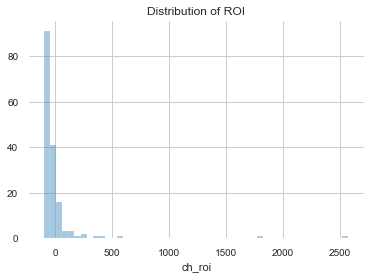

In [16]:
ax = sns.distplot(df.ch_roi, kde=False)
ax.set_title('Distribution of ROI')
plt.show()

* two outliers with very high ROI

In [17]:
df[df.ch_roi>1000][['post_id', 'ch_id', 'ch_country', 'category', 'ch_subscriber_count']]

,post_id,ch_id,ch_country,category,ch_subscriber_count
50,n3uct0WF0KQ,UCZGVB6g74LXWtkR3fX50ykg,HK,[24],117000
101,KRuQ2S003ns,UCRWRClsBI3p9gnYO8UBst2g,GB,"[24, 22]",55100


* Possibly should exclude 
* Experimented with and without them
* Decided to leave them in because:
 * Don't have the subject matter expertise to identify true outliers
 * With very little data and without SME general approach is to keep the process as simple as possible


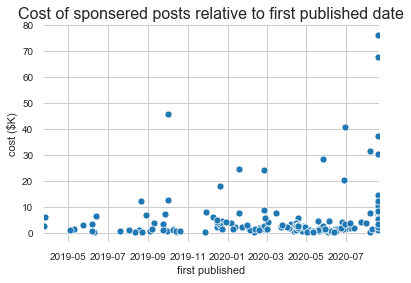

In [18]:
ax = sns.scatterplot(df.date_published.dt.date, df.cost)
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: f'{y/1000:,.0f}'))

ax.set_xlim((df.date_published.min(), df.date_published.max()))

ax.set_xlabel('first published')
ax.set_ylabel('cost ($K)')
ax.set_title('Cost of sponsered posts relative to first published date', fontsize=16)

plt.show()


* Rising costs with later puplished dates 
* Where multiple posts are aggregated is the lastest first_published value used?

In [21]:
# count channels from each country
country_count = df.groupby('ch_country').post_id.count() \
    .reset_index().rename(columns={'post_id':'country_count'}) \
    .sort_values('country_count', ascending=False)


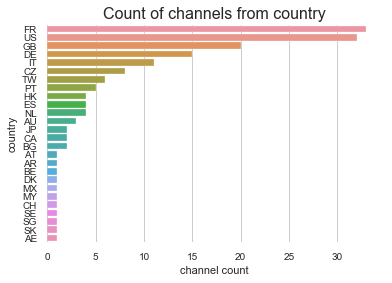

In [20]:
ax = sns.barplot(x='country_count', y='ch_country', data=country_count, orient='h', order=country_count.ch_country)
ax.set_xlabel('channel count')
ax.set_ylabel('country')
ax.set_title('Count of channels from country', fontsize=16)
plt.show()

In [22]:
# count channels assigned to each category
category_count = df.explode('category').groupby('category').post_id.count() \
    .reset_index().rename(columns={'post_id':'category_count'}) \
    .sort_values('category_count', ascending=False)

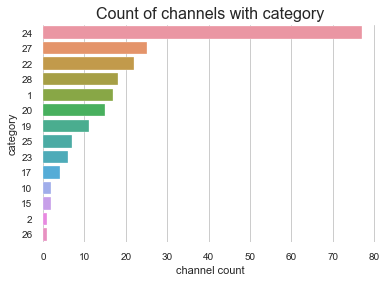

In [23]:
ax = sns.barplot(x='category_count', y='category', data=category_count, orient='h', order=category_count.category)
ax.set_xlabel('channel count')
ax.set_title('Count of channels with category', fontsize=16)
plt.show()

#### Choose one main category for each channel
Where a channel has multiple channels pick their category that is most common for the brand.
Given that most channels only have one, it is simpler to model the category as a single value.

In [24]:
df['main_category'] = None
for i, row in df.iterrows():
    if len(row.category) == 1:
        df.loc[i, 'main_category'] = int(row.category[0])
    else:
        cat = category_count.loc[category_count.category \
                                    .isin(row.category)] \
                                    .sort_values('category_count') \
                                    .category.values[-1]     
        df.loc[i, 'main_category'] = int(cat)

### Build the model



Because of
* Small amount of data a reggression model is a good choice
* Non normal data that would require signicant transformation ruled out standard linear regression
* As does possbile non linear dynamics between variables
* Relatively large number of variables that could cause over fitting

Decided to use a **Random Forest Regression model**

Given the possible importance of the two categorical variables (country and category) decided to use H2O's RFR model, that treats categorical variables as a single variable rather than the sklearn approach to one hot encode them. 

I did experiment with various changes to the features and creating new features, eg., average likes, that could improve the result. Also looked at applying a correction factor to the RFR prediction that improved the accuracy. But with the limited data and time, it is difficult to know what is genuine signal and what is random luck and overfitting.

Because of this and the lack of subject matter experties I decided to keep the presented model as standard as possible, with the minimum level of optimisation.

I have also not included cost in the indpendent variables, because I don't know if channels that were succesful went on to have multiple sponsored posts.


In [25]:
import h2o
from h2o.estimators import H2ORandomForestEstimator

In [28]:
h2o.init()
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Europe/London
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.1
H2O_cluster_version_age:,22 days
H2O_cluster_name:,H2O_from_python_leo_724unj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.768 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


In [30]:
# turn the dataframe into an h2o frame
hf = h2o.H2OFrame(df[[
    'ch_id',
    'ch_country', 
    'main_category', 
    'ch_subscriber_count', 
    'ch_avg10_views',
    'ch_avg10_likes_per_dislikes', 
    'ch_avg10_likes_per_rates',
    'ch_avg10_likes_per_views', 
    'ch_avg10_comments_per_views',
    'ch_avg10_views_per_subs', 
    'ch_avg10_duration_m', 
    'ch_revenue', 
    'sales', 
    'cost', 
    'ch_roi'
]])

# the independent variables
predictors = [
    'ch_country', 
    'main_category', 
    'ch_subscriber_count', 
    'ch_avg10_views',
    'ch_avg10_likes_per_dislikes', 
    'ch_avg10_likes_per_rates',
    'ch_avg10_likes_per_views', 
    'ch_avg10_comments_per_views',
    'ch_avg10_views_per_subs', 
    'ch_avg10_duration_m',
    # 'cost'
]

# the dependent variable
response = 'ch_roi'


# split the data for training and validation
train, valid = hf.split_frame(ratios=[.7], seed=1)

In [31]:
# Build and train the model:
drf = H2ORandomForestEstimator(
    ntrees=100,
    max_depth=10,
    min_rows=10,
    calibration_frame=valid,
)

drf.train(
    x=predictors,
    y=response,
    training_frame=train,
    validation_frame=valid
)

In [32]:
# evaluate the performance
perf = drf.model_performance()

In [33]:
# get the predictions from the validation set
pred = drf.predict(valid)

In [34]:
drf

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1598978238436_1


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,100.00,100.00,"13,331.00",3.00,6.00,3.68,4.00,8.00,5.94




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 82227.47291098245
RMSE: 286.7533311244744
MAE: 98.39752469283891
RMSLE: NaN
Mean Residual Deviance: 82227.47291098245

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 18772.50302158867
RMSE: 137.012784153847
MAE: 85.16239143109036
RMSLE: NaN
Mean Residual Deviance: 18772.50302158867

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance,validation_rmse,validation_mae,validation_deviance
0,,2020-09-01 17:37:48,0.020 sec,0.00,nan,nan,nan,nan,nan,nan
1,,2020-09-01 17:37:48,0.106 sec,1.00,116.52,74.55,"13,576.13",167.39,105.22,"28,017.98"
2,,2020-09-01 17:37:48,0.125 sec,2.00,117.18,74.49,"13,732.22",170.65,102.29,"29,119.75"
3,,2020-09-01 17:37:48,0.133 sec,3.00,348.72,112.83,"121,606.32",145.51,86.63,"21,174.12"
4,,2020-09-01 17:37:48,0.142 sec,4.00,323.83,107.26,"104,866.23",152.00,91.01,"23,102.66"
5,,2020-09-01 17:37:48,0.149 sec,5.00,307.08,103.46,"94,299.65",145.84,88.38,"21,268.80"
6,,2020-09-01 17:37:48,0.155 sec,6.00,310.00,108.91,"96,097.13",145.84,87.98,"21,270.33"
7,,2020-09-01 17:37:48,0.163 sec,7.00,299.10,107.88,"89,458.04",147.57,88.93,"21,778.17"
8,,2020-09-01 17:37:48,0.169 sec,8.00,294.81,105.44,"86,913.36",148.10,89.25,"21,934.25"
9,,2020-09-01 17:37:48,0.175 sec,9.00,288.22,101.98,"83,071.93",143.30,86.04,"20,534.34"



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,ch_country,"45,382,704.00",1.00,0.43
1,ch_avg10_likes_per_dislikes,"16,081,724.00",0.35,0.15
2,ch_avg10_views,"11,914,253.00",0.26,0.11
3,ch_avg10_likes_per_rates,"11,398,466.00",0.25,0.11
4,ch_subscriber_count,"6,515,181.50",0.14,0.06
5,ch_avg10_views_per_subs,"5,284,880.50",0.12,0.05
6,ch_avg10_likes_per_views,"3,576,421.50",0.08,0.03
7,ch_avg10_comments_per_views,"3,072,240.75",0.07,0.03
8,ch_avg10_duration_m,"1,511,685.12",0.03,0.01
9,main_category,"205,440.62",0.00,0.00


Average tree depth 3.6 implies some nonlinear interactions between the variables. But able to get similar results with tree depths of 1. So this would need more investigation.

The accuracy metrics of the validation set are actually lower than the training set. This is because of the outliers in the larger training set reducing the training accuracy.

Intepretation of model:
* The most important variable by a long way is country (43%)
* Noticeabley category has no impact on the model.

In [35]:
# combine the validation set actual roi with the predictions
pred_vs_actual = pd.concat([pred.as_data_frame(), valid.as_data_frame()[response]], axis=1) 
pred_vs_actual = pred_vs_actual.rename(columns={'predict':'predicted_roi','ch_roi':'actual_roi'})
pred_vs_actual.head()

,predicted_roi,actual_roi
0,-44.16,-44.06
1,-46.03,-71.70
2,-36.12,-98.84
3,-21.02,-57.70
4,-22.84,-85.86


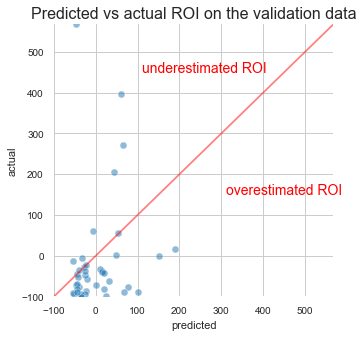

In [36]:
plt.figure(figsize=(5, 5))

ax = sns.scatterplot(x='predicted_roi', y='actual_roi', data=pred_vs_actual, alpha=0.5)

min_response = int(pred_vs_actual.min().min())
max_response = int(pred_vs_actual.max().max())

ax.set_xlim((min_response, max_response))
ax.set_ylim((min_response, max_response))

ax.set_xlabel('predicted')
ax.set_ylabel('actual')

ax.set_title('Predicted vs actual ROI on the validation data', fontsize=16)

plt.plot(range(min_response, max_response), range(min_response, max_response), color='r', alpha=0.5)
plt.text(310, 150, 'overestimated ROI', fontsize=14, color='r')
plt.text(110, 450, 'underestimated ROI', fontsize=14, color='r')


# from scipy.stats import pearsonr
# corr, _ = pearsonr(valid.as_data_frame()[response], pred.as_data_frame().predict)
# print(f'Pearsons correlation: {corr:.3f}')

plt.show()

We can see that the model tends to overestimate ROI, except for high performing channels where it massively underpredicts. 

This is caused by an imbalance in the sample and could be corrected for

Most of the channels that do actually have a positive ROI are predicted to have a positive ROI


In [37]:
# utilty functions 

def expected_response(df):
    hf = h2o.H2OFrame(df[predictors])  
    pred = drf.predict(hf).as_data_frame().predict.values 
    return pred

def total_roi(df):
    return (df.ch_revenue.sum() - df.cost.sum()) / df.cost.sum() * 100

Print the ROI for the training data, the validation data and the validation data excluding campaigns where the model predicts negative ROI

In [38]:
train_df = train.as_data_frame()
train_df['predicted_ch_roi'] = expected_response(train_df)

print(f'ROI {total_roi(train_df):.02f}% from {len(train_df)} campaigns\n')
print(f'sales {train_df.sales.sum():,}')
print(f'revenue £{train_df.ch_revenue.sum():,.0f}')
print(f'cost £{train_df.cost.sum():,.0f}')

ROI -17.45% from 120 campaigns

sales 5,739
revenue £500,546
cost £606,365


In [39]:
valid_df = valid.as_data_frame()
valid_df['predicted_ch_roi'] = expected_response(valid_df)

print(f'ROI {total_roi(valid_df):.02f}% from {len(valid_df)} campaigns\n')
print(f'sales {valid_df.sales.sum():,}')
print(f'revenue £{valid_df.ch_revenue.sum():,.0f}')
print(f'cost £{valid_df.cost.sum():,.0f}')

ROI -17.33% from 42 campaigns

sales 2,530
revenue £242,099
cost £292,840


In [40]:
valid_ex_df = valid.as_data_frame()
valid_ex_df['predicted_ch_roi'] = expected_response(valid_ex_df)
valid_ex_df = valid_ex_df.loc[valid_ex_df.predicted_ch_roi>0] 

print(f'ROI {total_roi(valid_ex_df):.02f}% from {len(valid_ex_df)} campaigns\n')
print(f'sales {valid_ex_df.sales.sum():,}')
print(f'revenue £{valid_ex_df.ch_revenue.sum():,.0f}')
print(f'cost £{valid_ex_df.cost.sum():,.0f}')

ROI 18.12% from 18 campaigns

sales 1,529
revenue £154,490
cost £130,786


We can see the training and validation datasets give similar combined ROI -17% for their respective channels

But when we exclude campaigns in the validation set, that the model has predicted will have negative ROI, we then see an improvement in the actual combined ROI from -17% to +18%

In [41]:
all_df = df.copy()

all_df['predicted_ch_roi'] = expected_response(df)

In [42]:
# calculate the cumulative values for looking at the threshold impact
all_df = all_df.sort_values('predicted_ch_roi', ascending=False).reset_index()
all_df['cum_sales'] = all_df.sales.cumsum()
all_df['cum_views'] = all_df.view_count.cumsum()
all_df['cum_revenue'] = all_df.ch_revenue.cumsum()
all_df['cum_cost'] = all_df.cost.cumsum()
all_df['cum_profit'] = all_df.cum_revenue - all_df.cum_cost
all_df['cum_roi'] = (all_df.cum_revenue - all_df.cum_cost) / all_df.cum_cost * 100
all_df.head() 

,index,post_id,ch_id,ch_country,category,first_published,ch_subscriber_count,ch_avg10_views,ch_avg10_likes_per_dislikes,ch_avg10_likes_per_rates,ch_avg10_likes_per_views,ch_avg10_comments_per_views,ch_avg10_views_per_subs,ch_avg10_duration_m,view_count,ch_revenue,sales,cost,date_published,ch_roi,main_category,predicted_ch_roi,cum_sales,cum_views,cum_revenue,cum_cost,cum_profit,cum_roi
0,50,n3uct0WF0KQ,UCZGVB6g74LXWtkR3fX50ykg,HK,[24],"1,590,450,000,000.00",117000,"42,925.90",51.21,0.98,6.37,0.36,0.37,9.36,73397,"39,749.13",323,"1,484.23",2020-05-25 23:40:00,"2,578.10",24,212.32,323,73397,"39,749.13","1,484.23","38,264.90","2,578.10"
1,101,KRuQ2S003ns,UCRWRClsBI3p9gnYO8UBst2g,GB,"[24, 22]","1,592,090,000,000.00",55100,"30,780.27",44.61,0.98,14.50,5.18,0.61,30.66,113692,"5,731.53",55,302.61,2020-06-13 23:13:20,"1,794.03",24,204.21,378,187089,"45,480.66","1,786.84","43,693.82","2,445.31"
2,65,PaqPueBtYAo,UCKxQ3Dx6K95hpLpdJjTRIlg,GB,[28],"1,596,930,000,000.00",64700,"46,422.64",52.49,0.98,4.16,0.43,0.79,18.04,18960,460.68,4,390.38,2020-08-08 23:40:00,18.01,28,188.77,382,206049,"45,941.34","2,177.22","43,764.12","2,010.09"
3,140,LmW0WyZ_d_o,UCGzJvasHdP8PLDoh0RTw10w,HK,[28],"1,597,940,000,000.00",47800,"37,819.36",38.15,0.97,2.59,0.26,1.11,21.41,319200,"10,326.62",85,"10,462.97",2020-08-20 16:13:20,-1.30,28,151.39,467,525249,"56,267.96","12,640.19","43,627.77",345.15
4,130,fm0lI7MQ0mo,UC726J5A0LLFRxQ0SZqr2mYQ,GB,[28],"1,593,480,000,000.00",886000,"388,544.00",48.95,0.98,3.83,0.42,0.53,17.96,5486971,"50,835.84",505,"40,637.51",2020-06-30 01:20:00,25.10,28,120.64,972,6012220,"107,103.80","53,277.70","53,826.10",101.03


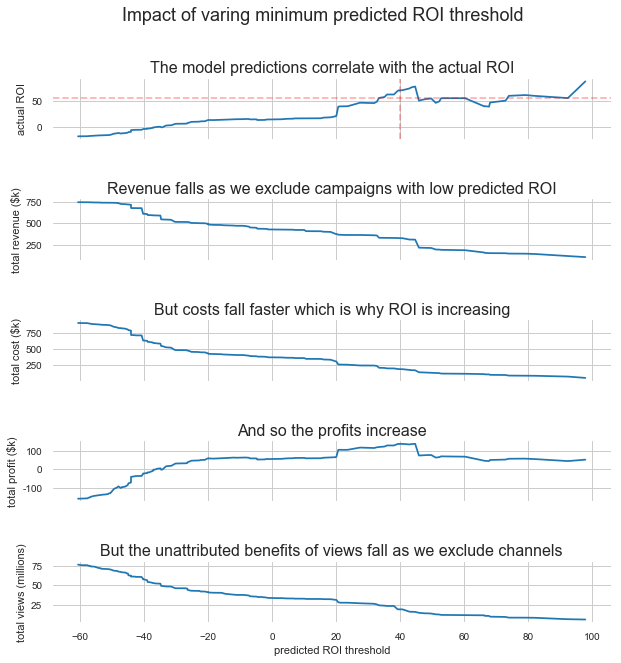

In [43]:
# plot the graphs of the cumulative values 

sns.set_style('whitegrid')

data = all_df[all_df.predicted_ch_roi<100]

f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True)

plt.subplots_adjust(hspace=1)

plt.suptitle('Impact of varing minimum predicted ROI threshold', fontsize=18)


i = 0
axes[i].set_title('The model predictions correlate with the actual ROI', fontsize=16)
sns.lineplot(x='predicted_ch_roi', y='cum_roi', data=data, ax=axes[i])

axes[i].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: format(int(y), ',')))

# axes[i].set_xlabel('predicted ROI threshold')
axes[i].set_ylabel('actual ROI')

axes[i].axhline(y=55, xmin=0, xmax=1, color='r', linestyle='--', alpha=0.3)
axes[i].axvline(x=40, ymin=0, ymax=1, color='r', linestyle='--', alpha=0.3)


i += 1
axes[i].set_title('Revenue falls as we exclude campaigns with low predicted ROI', fontsize=16)

sns.lineplot(x='predicted_ch_roi', y='cum_revenue', data=data, ax=axes[i])

axes[i].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: f'{y/1000:,.0f}'))

# axes[i].set_xlabel('predicted ROI threshold')
axes[i].set_ylabel('total revenue ($k)')


i += 1
axes[i].set_title('But costs fall faster which is why ROI is increasing', fontsize=16)

sns.lineplot(x='predicted_ch_roi', y='cum_cost', data=data, ax=axes[i])

axes[i].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: f'{y/1000:,.0f}'))

# axes[i].set_xlabel('predicted ROI threshold')
axes[i].set_ylabel('total cost ($k)')


i += 1
axes[i].set_title('And so the profits increase', fontsize=16)

sns.lineplot(x='predicted_ch_roi', y='cum_profit', data=data, ax=axes[i])

axes[i].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: f'{y/1000:,.0f}'))

# axes[i].set_xlabel('predicted ROI threshold')
axes[i].set_ylabel('total profit ($k)')


i += 1
axes[i].set_title('But the unattributed benefits of views fall as we exclude channels', fontsize=16)
sns.lineplot(x='predicted_ch_roi', y='cum_views', data=data, ax=axes[i])

axes[i].get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda y, p: f'{y/1000000:,.0f}'))

axes[i].set_xlabel('predicted ROI threshold')
axes[i].set_ylabel('total views (millions)')


# min_fill = -50
# max_fill = 100
# fill_alpha = 0.05
# for i in range(5):
#     axes[i].fill_betweenx(axes[i].get_ylim(), min_fill, max_fill, facecolor='grey', alpha=fill_alpha)


plt.show()

### But how do we select the right threshold?

What is the optimal minimum value of predicted ROI to use a channel for a sponsored post.

In these graphs we exclude channels where the model **predicted** a low ROI and look at the impact would have been on **actual** ROI 


**How to read the graphs**:

* As we move from left to right along the x-axis we are excluding all the channels that have a predicted ROI below the x-axis value. 

* And the y-axis tells us the total value for the remaining channels.

* So for example on the top graph. Setting the threshold at +40% and excluding all channels with a **predicted** ROI less than 40, we then would have got from the remaing channels a combined **actual** ROI of just over +50%


When selecting the right threshold the brand would want to find the right balance of ROI and revenue along with the unknown and unattributed value of views.

This could be manually selected on campaign by campaign basis or dynamically selected by an algorithm. Also it may be that the threshold could change over the lifetime of the campaign. Starting quite low to maximise views and test a wide range of channels. Then as the campaign progresses and more data is collected and the model learns and improves the threshold could be increased to focus in on channels expected to maximise ROI.
